<a href="https://www.kaggle.com/code/sonujha090/dogs-vs-cats-pytorch?scriptVersionId=114239526" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [89]:
from fastai.vision.all import *

In [90]:
sample_submission = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
sample_submission.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [91]:
if not os.path.exists('data'):
    os.mkdir('data')

In [92]:
%%time 
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip -d data/

replace data/test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
CPU times: user 1.62 s, sys: 251 ms, total: 1.87 s
Wall time: 1min 55s


In [93]:
%%time 
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip -d data/

replace data/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
CPU times: user 94.3 ms, sys: 61.9 ms, total: 156 ms
Wall time: 7.89 s


In [94]:
path = Path("data")
Path.BASE_PATH = path
path.ls()

(#2) [Path('test'),Path('train')]

In [95]:
(path/'train').ls()

(#25000) [Path('train/cat.8001.jpg'),Path('train/cat.5263.jpg'),Path('train/cat.2336.jpg'),Path('train/cat.9020.jpg'),Path('train/cat.4956.jpg'),Path('train/dog.1395.jpg'),Path('train/cat.4039.jpg'),Path('train/dog.8329.jpg'),Path('train/cat.9289.jpg'),Path('train/dog.10721.jpg')...]

In [96]:
one_img = (path/'train').ls()[0]
one_img.name.split('.')[0]

'cat'

In [97]:
train_img_dir = path/'train'
label_fn = lambda x: x.name.split('.')[0]
images = get_image_files(train_img_dir)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

# taking a subset of the data for faster training
dls = dblock.dataloaders(train_img_dir)

In [98]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

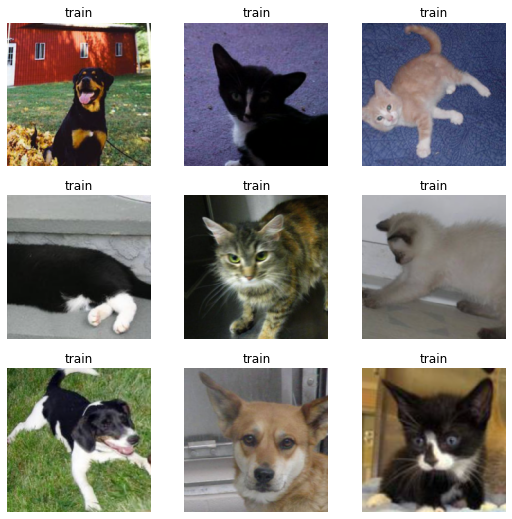

In [99]:
dls.show_batch()

In [100]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [101]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,05:11


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,05:05
1,0.000000,0.000000,0.000000,05:03


In [102]:
# predict
img = PILImage.create('data/test/1.jpg')
img.to_thumb(128,128)
learn.predict(img)

('train', TensorBase(0), TensorBase([1.]))

# Prediction on test dataset

In [103]:
# creating test dataloader
test_dl = learn.dls.test_dl(get_image_files(path/'test'))

In [104]:
%%time
preds, _ = learn.get_preds(dl=test_dl)

CPU times: user 11.2 s, sys: 2.6 s, total: 13.8 s
Wall time: 2min 19s


In [36]:
# class 1 is the dog class and class 0 is the cat class
preds = preds[:,1]

(array([6164.,   44.,   32.,   29.,   33.,   30.,   23.,   36.,   68.,
        6041.]),
 array([3.0122907e-12, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

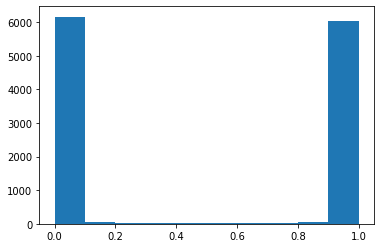

In [37]:
plt.hist(preds)

In [43]:
# creating the submission dataframe
submission_df = pd.DataFrame({'id': [int(x.stem) for x in test_dl.items], 'label': preds})
submission_df.head()

,id,label
0,9211,5.962682e-05
1,4379,5.669882e-05
2,4087,2.893761e-08
3,1151,9.999983e-01
4,9735,4.493845e-05


In [46]:
# saving the submission dataframe
submission_df.to_csv('submission.csv', index=False)